In [35]:
import os
import sys

def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/MEC_Stackelberg_Project'
else:
    # 自动根据当前脚本定位项目根路径
    PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname(__file__), '..')) \
        if '__file__' in globals() else os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

print(f"项目路径设置为: {PROJECT_PATH}")

项目路径设置为: c:\Users\a1831\Desktop\MEC_Stackelberg_Project


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import src.models as models
import src.config as config
import src.run_experiment as run_experiment
import src.utils as utils
import src.algorithms.Stackelberg_solver as stackelberg_solver
import src.algorithms.user_game_solver as user_game_solver
import src.algorithms.baseline_solver as baseline_solver
import src.algorithms.previous_work as previous_work

SEED = 43

In [38]:
SWEEPER_PATH = os.path.join(PROJECT_PATH, "configs", "sweep_num_user.json")
sweeper = run_experiment.ParamSweeper(SWEEPER_PATH)
configs = sweeper.sweep_configs()
print(configs)

sweep_user_provider = []
for i,config in enumerate(configs):
  users = run_experiment.create_users(config,SEED,True)
  provider = run_experiment.create_provider(config)
  sweep_user_provider.append((users,provider))

[<src.config.Config object at 0x0000019601D23A50>, <src.config.Config object at 0x000001960312F690>, <src.config.Config object at 0x000001960312CC90>, <src.config.Config object at 0x000001967048E990>, <src.config.Config object at 0x0000019602D47710>]


In [39]:
tu, tp = sweep_user_provider[0][0], sweep_user_provider[0][1]
for u in tu:
    print(u.user_id)
    u.print_user()
    u.print_bounds(1e-1,1e-1)
    u.print_costs(1e-1,1e-1)
tp.print_providers()

0
 task: d= 0.7301091327795579  b= 51.852790828122664  alpha= 10.666954820929941
 local cpu= 1.1013962436640183
 S_i= 29.35127707894157
 f_{thres}_ 0 = 1.8823904182590745  B_{thres}_ 0 = 3.827622483287052
 f_{hat}_ 0 = 8.824987894443755  B_{hat}_ 0 = 13.727542430103586
 C^l_ 0 = 7.0710620074382895  C_hat_e_ 0 = 4.510506064909468
 C_{hat}_ef_ 0 = 1.764997578888751  C_{hat}_eb_ 0 = 2.745508486020717
1
 task: d= 1.8321804261960515  b= 46.963679284405075  alpha= 10.145069122121802
 local cpu= 1.0614329830400666
 S_i= 31.75781288118785
 f_{thres}_ 1 = 1.2443447401601482  B_{thres}_ 1 = 1.0217742693416199
 f_{hat}_ 1 = 13.633633803193309  B_{hat}_ 1 = 12.24851022965479
 C^l_ 1 = 17.511795247515767  C_hat_e_ 1 = 5.1764288065696205
 C_{hat}_ef_ 1 = 2.726726760638662  C_{hat}_eb_ 1 = 2.4497020459309584
2
 task: d= 1.0088422517197586  b= 12.09571543888293  alpha= 14.333243204496
 local cpu= 0.7212675297127461
 S_i= 29.372148451780856
 f_{thres}_ 2 = 0.7844614080490686  B_{thres}_ 2 = 0.335191702

In [10]:
EPF_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_epf.log")
EPF_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_epf.json")

TU_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.log")
TU_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.json")

BNB_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.log")
BNB_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.json")

RAND_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.log")
RAND_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.json")


ORACLE_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_oracle.log")
ORACLE_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_oracle.json")

In [17]:
"""
jiadi liu epf Sweep
"""
sweep_results_epf = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  pe_epf, pn_epf, X_epf, U_epf, results_epf = previous_work.epf_baseline(users,provider,initial_p_E=provider.c_E+0.1,initial_p_N=provider.c_N+0.1)
  sp_info={
      "X": list(X_epf),
      "U_X": U_epf,
      "p_E": pe_epf,
      "p_N": pn_epf,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_epf], provider, pe_epf, pn_epf)
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_epf]),
      "sum_f": min(np.sum(of),provider.f_max),
      "sum_b": min(np.sum(ob),provider.B_max),
      "f_utilization": min(np.sum(of)/provider.f_max,1),
      "b_utilization": min(np.sum(ob)/provider.B_max,1)
  }
  user_info = [u.log_info(pe_epf, pn_epf) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_epf.append(res)

utils.log_sweep_experiments_results(sweep_results_epf, EPF_LOG_PATH)
with open(EPF_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_epf, f, ensure_ascii=False, indent=2)

c:\Users\a1831\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
2025-04-04 16:03:37,175 - INFO - ===== Sweep Experiments Results =====
2025-04-04 16:03:37,176 - INFO - ===== Experiment 1 =====
2025-04-04 16:03:37,176 - INFO - ----- Single Experiment Result -----
2025-04-04 16:03:37,177 - INFO - Sweep Parameter: num_users
2025-04-04 16:03:37,178 - INFO - SP Info:
{
  "X": [
    1,
    2,
    4,
    6,
    7,
    8,
    9
  ],
  "U_X": 13.496521917037988,
  "p_E": 0.10949652191703799,
  "p_N": 0.11000000000000001,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 16:03:37,178 - INFO - User Game Info:
{
  "f": [
    12.980603230471715,
    11.491684768406397,
    11.503276661997068,
    14.930773566839498,
    16.197140046230267,
    12.696332681115376,
    15.372180661306142
  ],
  "b": [
    5.2739028169

In [ ]:
"""
Tutuncuoglu Sweep
"""
TU_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.log")
TU_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_tu.json")
# 如果存在 checkpoint，先读取它
if os.path.exists(TU_JSON_PATH):
    print("📦 检测到已有结果文件，尝试恢复中...")
    with open(TU_JSON_PATH, "r", encoding="utf-8") as f:
        sweep_results_tu = json.load(f)
    start_index = len(sweep_results_tu)
    print(f"🔁 已完成 {start_index}/{len(sweep_user_provider)} 个参数，准备从第 {start_index + 1} 个开始")
else:
    sweep_results_tu = []
    start_index = 0


for i in range(start_index, len(sweep_user_provider)):
  print(f"\n🌀 Running sweep {i+1}/{len(sweep_user_provider)} ...")
  try:
    users, provider = up[0], up[1]
    X_tu, U_tu, p_tu, results_tu = previous_work.tutuncuoglu_exhaustive_search(users,provider)
    sp_info={
        "X": list(X_tu),
        "U_X": U_tu,
        "p": p_tu,
        "f_max": provider.f_max,
        "B_max": provider.B_max,
        "c_E": provider.c_E,
        "c_N": provider.c_N
    }
    best_result_tt = next((r for r in results_tu if r["X"] == X_tu), None)
    sum_f_tt, sum_b_tt = best_result_tt["sum_f"], best_result_tt["sum_b"]
    f, b = best_result_tt["f"], best_result_tt["b"]
    user_game_info = {
        "f": list(f),
        "b": list(b),
        "sum_offload_cost": np.sum([u.cost_local() for u in users if u.user_id in X_tu]),
        "social_cost": np.sum([u.cost_local() for u in users]),
        "sum_f": sum_f_tt,
        "sum_b": sum_b_tt,
        "f_utilization": sum_f_tt/provider.f_max,
        "b_utilization": sum_b_tt/provider.B_max
    }
    user_info = []
    res={
        "sweep_param": sweep_param,
        "sweep_value": sweep_values[i],
        "sp_info": sp_info,
        "user_game_info": user_game_info,
        "user_info": user_info
    }
    sweep_results_tu.append(res)
            # 保存进度
    with open(TU_JSON_PATH, "w", encoding="utf-8") as f:
        json.dump(sweep_results_tu, f, ensure_ascii=False, indent=2)

    utils.log_sweep_experiments_results(sweep_results_tu, TU_LOG_PATH)
    print(f"✅ 完成 sweep {i+1}/{len(sweep_user_provider)}")

  except Exception as e:
      print(f"💥 第 {i+1} 个参数出错：{e}")
      continue

print("\n🏁 所有参数 sweep 完成！")

In [ ]:
# 保存路径
BNB_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.json")
BNB_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_bnb.log")

# 如果存在 checkpoint，先读取它
if os.path.exists(BNB_JSON_PATH):
    print("📦 检测到已有结果文件，尝试恢复中...")
    with open(BNB_JSON_PATH, "r", encoding="utf-8") as f:
        sweep_results_bnb = json.load(f)
    start_index = len(sweep_results_bnb)
    print(f"🔁 已完成 {start_index}/{len(sweep_user_provider)} 个参数，准备从第 {start_index + 1} 个开始")
else:
    sweep_results_bnb = []
    start_index = 0

# 正式开始 sweep
for i in range(start_index, len(sweep_user_provider)):
    print(f"\n🌀 Running sweep {i+1}/{len(sweep_user_provider)} ...")
    try:
        users, provider = sweep_user_provider[i]
        pe_bnb, pn_bnb, X_bnb, U_bnb, results_bnb = stackelberg_solver.branch_and_bound(users, provider)

        sp_info = {
            "X": list(X_bnb),
            "U_X": U_bnb,
            "p_E": pe_bnb,
            "p_N": pn_bnb,
            "f_max": provider.f_max,
            "B_max": provider.B_max,
            "c_E": provider.c_E,
            "c_N": provider.c_N
        }

        of, ob, oc = models.ora_solver(
            [u for u in users if u.user_id in X_bnb],
            provider,
            pe_bnb,
            pn_bnb
        )

        user_game_info = {
            "f": list(of),
            "b": list(ob),
            "sum_offload_cost": oc,
            "social_cost": oc + np.sum([u.cost_local() for u in users if u.user_id not in X_bnb]),
            "sum_f": np.sum(of),
            "sum_b": np.sum(ob),
            "f_utilization": np.sum(of) / provider.f_max,
            "b_utilization": np.sum(ob) / provider.B_max
        }

        user_info = [u.log_info(pe_bnb, pn_bnb) for u in users]

        res = {
            "sweep_param": sweeper.vary_param,
            "sweep_value": sweeper.values[i],
            "sp_info": sp_info,
            "user_game_info": user_game_info,
            "user_info": user_info
        }

        sweep_results_bnb.append(res)

        # 保存进度
        with open(BNB_JSON_PATH, "w", encoding="utf-8") as f:
            json.dump(sweep_results_bnb, f, ensure_ascii=False, indent=2)

        utils.log_sweep_experiments_results(sweep_results_bnb, BNB_LOG_PATH)
        print(f"✅ 完成 sweep {i+1}/{len(sweep_user_provider)}")

    except Exception as e:
        print(f"💥 第 {i+1} 个参数出错：{e}")
        continue

print("\n🏁 所有参数 sweep 完成！")

X_init= {1, 3}


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:498: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible


/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:86: RuntimeWarning: invalid value encountered in sqrt
  f_thresh = ((C_l_i - C_hat_eb_i) - np.sqrt((C_l_i - C_hat_eb_i)**2 - C_hat_ef_i**2)) / (2*p_E)
/content/drive/MyDrive/MEC_Stackelberg_Project/src/models.py:93: RuntimeWarning: invalid value encountered in sqrt
  B_thresh = ((C_l_i - C_hat_ef_i) - np.sqrt((C_l_i - C_hat_ef_i)**2 - C_hat_eb_i**2)) / (2*p_N)


X_init= {0, 1, 2, 3, 4, 11, 12}
X_init= {0, 2, 5, 8, 10, 13, 14, 18}
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization

2025-04-04 01:48:14,645 - INFO - ===== Sweep Experiments Results =====
INFO:sweeper_logger:===== Sweep Experiments Results =====
2025-04-04 01:48:14,648 - INFO - ===== Experiment 1 =====
INFO:sweeper_logger:===== Experiment 1 =====
2025-04-04 01:48:14,652 - INFO - ----- Single Experiment Result -----
INFO:sweeper_logger:----- Single Experiment Result -----
2025-04-04 01:48:14,654 - INFO - Sweep Parameter: num_users
INFO:sweeper_logger:Sweep Parameter: num_users
2025-04-04 01:48:14,656 - INFO - SP Info:
{
  "X": [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    9
  ],
  "U_X": 67.83447442019266,
  "p_E": 2.1032305149,
  "p_N": 0.4031845879,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
INFO:sweeper_logger:SP Info:
{
  "X": [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    9
  ],
  "U_X": 67.83447442019266,
  "p_E": 2.1032305149,
  "p_N": 0.4031845879,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 01:48:14,658 - INFO - User Game Info:


In [44]:
"""
Random Sweep
"""

def default_converter(o):
    if isinstance(o, (np.int_, np.int32, np.int64)):
        return int(o)
    if isinstance(o, (np.float_, np.float32, np.float64)):
        return float(o)
    raise TypeError(f"Object of type {o.__class__.__name__} is not JSON serializable")

# 文件路径
RAND_LOG_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.log")
RAND_JSON_PATH = os.path.join(PROJECT_PATH, "results", "sweep_num_user_rand.json")

# 检查是否有 checkpoint
if os.path.exists(RAND_JSON_PATH):
    print("📦 检测到 Random Sweep 的结果文件，恢复中...")
    with open(RAND_JSON_PATH, "r", encoding="utf-8") as f:
        sweep_results_random = json.load(f)
    start_index = len(sweep_results_random)
    print(f"🔁 已完成 {start_index}/{len(sweep_user_provider)}，从第 {start_index + 1} 个参数继续")
else:
    sweep_results_random = []
    start_index = 0

# 扫描开始
for i in range(start_index, len(sweep_user_provider)):
    print(f"\n🎲 Running Random sweep {i+1}/{len(sweep_user_provider)} ...")
    try:
        users, provider = sweep_user_provider[i]

        X_rand, p_rand, U_rand, results_rand = baseline_solver.random_offloader_baseline(users, provider, 10)

        sp_info = {
            "X": list(X_rand),
            "U_X": U_rand,
            "p_E": p_rand[0],
            "p_N": p_rand[1],
            "f_max": provider.f_max,
            "B_max": provider.B_max,
            "c_E": provider.c_E,
            "c_N": provider.c_N
        }

        of, ob, oc = models.ora_solver(
            [u for u in users if u.user_id in X_rand],
            provider,
            p_rand[0],
            p_rand[1]
        )

        user_game_info = {
            "f": list(of),
            "b": list(ob),
            "sum_offload_cost": oc,
            "social_cost": oc + np.sum([u.cost_local() for u in users if u.user_id not in X_rand]),
            "sum_f": np.sum(of),
            "sum_b": np.sum(ob),
            "f_utilization": np.sum(of) / provider.f_max,
            "b_utilization": np.sum(ob) / provider.B_max
        }

        user_info = [u.log_info(p_rand[0], p_rand[1]) for u in users]

        res = {
            "sweep_param": sweeper.vary_param,
            "sweep_value": sweep_values[i],
            "sp_info": sp_info,
            "user_game_info": user_game_info,
            "user_info": user_info
        }

        sweep_results_random.append(res)

        # # 保存 JSON
        with open(RAND_JSON_PATH, "w", encoding="utf-8") as f:
            json.dump(sweep_results_random, f, ensure_ascii=False, indent=2, default=default_converter)

        # 写日志
        utils.log_sweep_experiments_results(sweep_results_random, RAND_LOG_PATH)
        print(f"✅ Random sweep {i+1} 完成")

    except Exception as e:
        print(f"💥 参数 {i+1} 出错：{e}")
        continue

print("\n🎉 Random Sweep 全部完成啦。你又一次没让整个项目灭绝。奇迹。")

📦 检测到 Random Sweep 的结果文件，恢复中...
🔁 已完成 2/5，从第 3 个参数继续

🎲 Running Random sweep 3/5 ...
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequali

c:\Users\a1831\Desktop\MEC_Stackelberg_Project\src\models.py:86: RuntimeWarning: invalid value encountered in sqrt
  f_thresh = ((C_l_i - C_hat_eb_i) - np.sqrt((C_l_i - C_hat_eb_i)**2 - C_hat_ef_i**2)) / (2*p_E)
c:\Users\a1831\Desktop\MEC_Stackelberg_Project\src\models.py:93: RuntimeWarning: invalid value encountered in sqrt
  B_thresh = ((C_l_i - C_hat_ef_i) - np.sqrt((C_l_i - C_hat_ef_i)**2 - C_hat_eb_i**2)) / (2*p_N)
2025-04-04 22:39:29,892 - INFO - ===== Sweep Experiments Results =====
2025-04-04 22:39:29,893 - INFO - ===== Experiment 1 =====
2025-04-04 22:39:29,894 - INFO - ----- Single Experiment Result -----
2025-04-04 22:39:29,894 - INFO - Sweep Parameter: num_users
2025-04-04 22:39:29,895 - INFO - SP Info:
{
  "X": [
    0,
    1,
    3,
    4,
    5,
    6,
    7,
    8,
    9
  ],
  "U_X": 23.426827177175323,
  "p_E": 0.31989460999999997,
  "p_N": 0.1012902149,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 22:39:29,895 - INFO - User Game Info:
{
  

Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
💥 参数 3 出错：Object of type int32 is not JSON serializable

🎲 Running Random sweep 4/5 ...
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivati

2025-04-04 22:41:07,967 - INFO - ===== Sweep Experiments Results =====
2025-04-04 22:41:07,968 - INFO - ===== Experiment 1 =====
2025-04-04 22:41:07,968 - INFO - ----- Single Experiment Result -----
2025-04-04 22:41:07,969 - INFO - Sweep Parameter: num_users
2025-04-04 22:41:07,969 - INFO - SP Info:
{
  "X": [
    0,
    1,
    3,
    4,
    5,
    6,
    7,
    8,
    9
  ],
  "U_X": 23.426827177175323,
  "p_E": 0.31989460999999997,
  "p_N": 0.1012902149,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 22:41:07,970 - INFO - User Game Info:
{
  "f": [
    4.934130787625369,
    7.622688336819051,
    5.39371380718554,
    6.730049614269516,
    4.443374487883801,
    8.735323841790596,
    9.477904517555515,
    7.4809423612862185,
    8.994594193784545
  ],
  "b": [
    5.63643818486335,
    1.8235777013181749,
    8.324566568857433,
    2.0031608282482574,
    13.36136718184457,
    1.8924408344474646,
    2.3214781695397675,
    2.793957958329587,
    1.8430

💥 参数 4 出错：Object of type int32 is not JSON serializable

🎲 Running Random sweep 5/5 ...
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Optimization failed: Inequality constraints incompatible
Optimization failed: Positive directional derivative for linesearch
Opti

2025-04-04 22:42:49,978 - INFO - ===== Sweep Experiments Results =====


Optimization failed: Inequality constraints incompatible
Optimization failed: Inequality constraints incompatible


2025-04-04 22:42:49,979 - INFO - ===== Experiment 1 =====
2025-04-04 22:42:49,979 - INFO - ----- Single Experiment Result -----
2025-04-04 22:42:49,979 - INFO - Sweep Parameter: num_users
2025-04-04 22:42:49,979 - INFO - SP Info:
{
  "X": [
    0,
    1,
    3,
    4,
    5,
    6,
    7,
    8,
    9
  ],
  "U_X": 23.426827177175323,
  "p_E": 0.31989460999999997,
  "p_N": 0.1012902149,
  "f_max": 100,
  "B_max": 40,
  "c_E": 0.01,
  "c_N": 0.01
}
2025-04-04 22:42:49,979 - INFO - User Game Info:
{
  "f": [
    4.934130787625369,
    7.622688336819051,
    5.39371380718554,
    6.730049614269516,
    4.443374487883801,
    8.735323841790596,
    9.477904517555515,
    7.4809423612862185,
    8.994594193784545
  ],
  "b": [
    5.63643818486335,
    1.8235777013181749,
    8.324566568857433,
    2.0031608282482574,
    13.36136718184457,
    1.8924408344474646,
    2.3214781695397675,
    2.793957958329587,
    1.843012572544828
  ],
  "sum_offload_cost": 110.40266852578681,
  "social_co

💥 参数 5 出错：Object of type int32 is not JSON serializable

🎉 Random Sweep 全部完成啦。你又一次没让整个项目灭绝。奇迹。


In [ ]:
"""
Oracle Sweep
"""
sweep_results_oracle = []
sweep_param = sweeper.vary_param
sweep_values = sweeper.values
for i,up in enumerate(sweep_user_provider):
  users, provider = up[0], up[1]
  pe_oracle, pn_oracle, X_oracle, U_oracle, results_oracle = baseline_solver.oracle_baseline_greedy(users, provider, (0.01,30.01),(0.01,30.01),400)
  sp_info={
      "X": list(X_oracle),
      "U_X": U_oracle,
      "p_E": pe_oracle,
      "p_N": pn_oracle,
      "f_max": provider.f_max,
      "B_max": provider.B_max,
      "c_E": provider.c_E,
      "c_N": provider.c_N
  }
  of, ob, oc = models.ora_solver([u for u in users if u.user_id in X_oracle], provider, pe_oracle, pn_oracle)
  user_game_info = {
      "f": list(of),
      "b": list(ob),
      "sum_offload_cost": oc,
      "social_cost": oc+np.sum([u.cost_local() for u in users if u.user_id not in X_oracle]),
      "sum_f": np.sum(of),
      "sum_b": np.sum(ob),
      "f_utilization": np.sum(of)/provider.f_max,
      "b_utilization": np.sum(ob)/provider.B_max
  }
  user_info = [u.log_info(pe_oracle, pn_oracle) for u in users]
  res={
      "sweep_param": sweep_param,
      "sweep_value": sweep_values[i],
      "sp_info": sp_info,
      "user_game_info": user_game_info,
      "user_info": user_info
  }
  sweep_results_oracle.append(res)

utils.log_sweep_experiments_results(sweep_results_oracle, ORACLE_LOG_PATH)
with open(ORACLE_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(sweep_results_oracle, f, ensure_ascii=False, indent=2)

File c:\Users\a1831\Desktop\MEC_Stackelberg_Project\results\sweep_num_user_oracle.json does not exist, skipping.


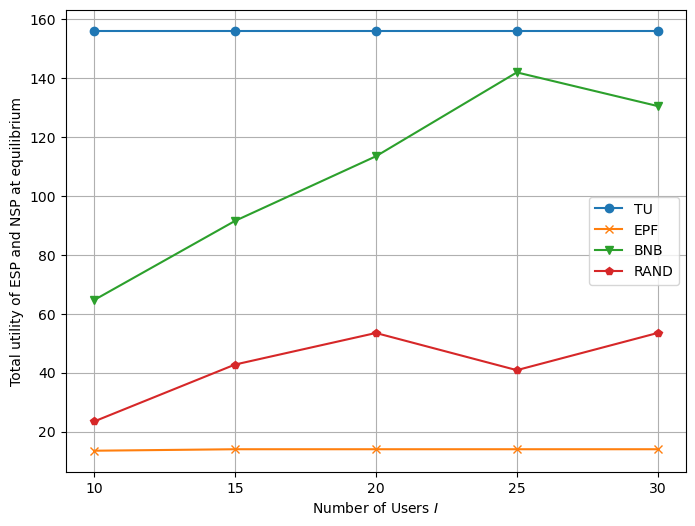

In [45]:
"""
图1a：用户数量 vs U_E+U_N
"""
result_paths = [TU_JSON_PATH,EPF_JSON_PATH,BNB_JSON_PATH,RAND_JSON_PATH,ORACLE_JSON_PATH]
markers=['o','x','v','p','s']
baseline_names = ["TU", "EPF", "BNB", "RAND", "ORACLE"]

plt.figure(figsize=(8,6))
for i,path in enumerate(result_paths):
    if not os.path.exists(path):
        print(f"File {path} does not exist, skipping.")
        continue
    with open(path, "r", encoding="utf-8") as f:
        sweep_results = json.load(f)
    # 提取横轴（num_user）和纵轴（U_X）数据
    num_users = []
    U_X = []
    for res in sweep_results:
        # 假设 sweep_param 为 "num_user"，sweep_value 就是用户数量
        num_users.append(res["sweep_value"])
        U_X.append(res["sp_info"]["U_X"])
    # 如果数据无序，可以先排序
    num_users, U_X = zip(*sorted(zip(num_users, U_X), key=lambda x: x[0]))
    # 绘图
    plt.plot(num_users, U_X, marker=markers[i], linestyle="-", label=baseline_names[i])

ax = plt.gca()
# 直接指定 x 轴主刻度位置为10, 15, 20, 25, 30, 35, 40, 45, 50
ax.set_xticks([10, 15, 20, 25, 30])
# 只绘制主刻度对应的网格线
ax.grid(True, which='major', linestyle='-', linewidth=0.8)
plt.xlabel("Number of Users $I$")
plt.ylabel("Total utility of ESP and NSP at equilibrium")
plt.legend()
plt.grid(True)
plt.show()

File c:\Users\a1831\Desktop\MEC_Stackelberg_Project\results\sweep_num_user_oracle.json does not exist, skipping.


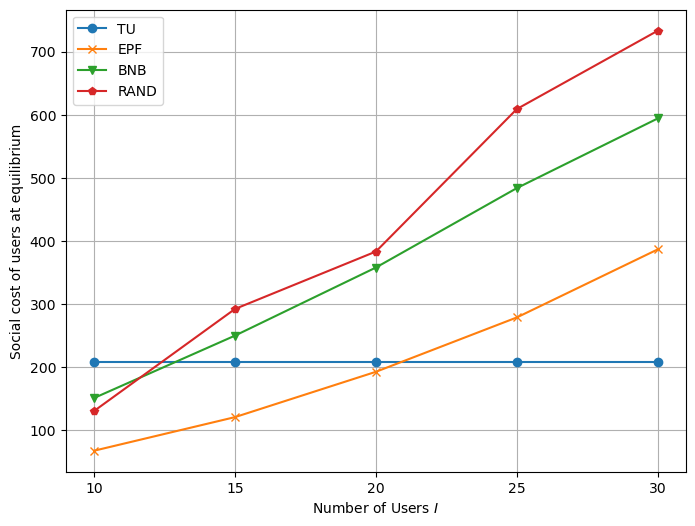

In [46]:
"""
图1b：用户数量 vs 用户Social Cost
"""
result_paths = [TU_JSON_PATH,EPF_JSON_PATH,BNB_JSON_PATH,RAND_JSON_PATH,ORACLE_JSON_PATH]
markers=['o','x','v','p','s']
baseline_names = ["TU", "EPF", "BNB", "RAND", "ORACLE"]

plt.figure(figsize=(8,6))
for i,path in enumerate(result_paths):
    if not os.path.exists(path):
        print(f"File {path} does not exist, skipping.")
        continue
    with open(path, "r", encoding="utf-8") as f:
        sweep_results = json.load(f)
    # 提取横轴（num_user）和纵轴（V_X）数据
    num_users = []
    V_X = []
    for res in sweep_results:
        # 假设 sweep_param 为 "num_user"，sweep_value 就是用户数量
        num_users.append(res["sweep_value"])
        V_X.append(res["user_game_info"]["social_cost"])
    # 如果数据无序，可以先排序
    num_users, V_X = zip(*sorted(zip(num_users, V_X), key=lambda x: x[0]))
    # 绘图
    plt.plot(num_users, V_X, marker=markers[i], linestyle="-", label=baseline_names[i])

ax = plt.gca()
# 直接指定 x 轴主刻度位置为10, 15, 20, 25, 30, 35, 40, 45, 50
ax.set_xticks([10, 15, 20, 25, 30])
# 只绘制主刻度对应的网格线
ax.grid(True, which='major', linestyle='-', linewidth=0.8)
plt.xlabel("Number of Users $I$")
plt.ylabel("Social cost of users at equilibrium")
plt.legend()
plt.grid(True)
plt.show()

File c:\Users\a1831\Desktop\MEC_Stackelberg_Project\results\sweep_num_user_oracle.json does not exist, skipping.


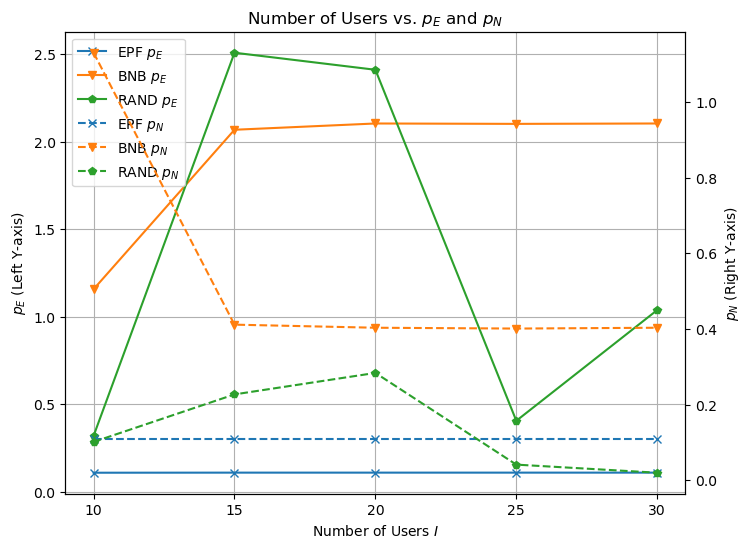

In [48]:
"""
图1c：用户数量 vs p_E, p_N
"""

result_paths = [ EPF_JSON_PATH, BNB_JSON_PATH, RAND_JSON_PATH, ORACLE_JSON_PATH]
markers = ['x', 'v', 'p', 's']
baseline_names = [ "EPF", "BNB", "RAND", "ORACLE"]

# 创建图和双坐标轴
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

# 用于存储每个baseline绘制的Line2D对象（便于构造图例）
lines_pE = []
lines_pN = []

for i, path in enumerate(result_paths):
    if not os.path.exists(path):
        print(f"File {path} does not exist, skipping.")
        continue
    with open(path, "r", encoding="utf-8") as f:
        sweep_results = json.load(f)
    
    num_users = []
    pes = []
    pns = []
    for res in sweep_results:
        # 假设 "sweep_value" 是用户数量
        num_users.append(res["sweep_value"])
        pes.append(res["sp_info"]["p_E"])
        pns.append(res["sp_info"]["p_N"])
    
    # 对数据按用户数量排序
    num_users, pes = zip(*sorted(zip(num_users, pes), key=lambda x: x[0]))
    num_users, pns = zip(*sorted(zip(num_users, pns), key=lambda x: x[0]))
    
    # 在左侧坐标轴绘制 p_E 曲线（实线）
    l1, = ax1.plot(num_users, pes, marker=markers[i], linestyle="-", label=f"{baseline_names[i]} $p_E$")
    # 在右侧坐标轴绘制 p_N 曲线（虚线）
    l2, = ax2.plot(num_users, pns, marker=markers[i], linestyle="--", label=f"{baseline_names[i]} $p_N$")
    
    lines_pE.append(l1)
    lines_pN.append(l2)

# 设置 x 轴刻度，只显示10, 15, 20, 25, 30
ax1.set_xticks([10, 15, 20, 25, 30])
ax1.set_xlabel("Number of Users $I$")
ax1.set_ylabel("$p_E$ (Left Y-axis)")
ax2.set_ylabel("$p_N$ (Right Y-axis)")

# 设置网格，只显示主要刻度网格
ax1.grid(True, which='major', linestyle='-', linewidth=0.8)

# 合并图例：将左侧和右侧的线对象合并，并放在图形合适位置
lines = lines_pE + lines_pN
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title("Number of Users vs. $p_E$ and $p_N$")
plt.show()